In [1]:
import numpy as np
import pandas as pd
import ecco_v4_py as ecco
import xarray as xr
from scipy.spatial import KDTree, cKDTree
import swot_ssh_utils as swot
import matplotlib.pyplot as plt
import sys
sys.path.append('/home3/sreich/MITgcm_c68w/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

from patchface3D import *
%load_ext autoreload
%autoreload 2

### Read in Grid Data

In [44]:
sNx=180
sNy=180

#grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
grid_dir='/nobackup/sreich/llc1080_c68w_runs/run/'
hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc[hfc!=0]=np.nan
# Convert to dict of 5 faces, sizes [(270,90), (270,90), (90,90), (90,270), (90,270)]
hfc_faces = ecco.llc_compact_to_faces(hfc, less_output=True)

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')


### Read in SWOT Data

In [46]:
# load swot data

#filename = 'SWOT_L2_LR_SSH_Expert_009_001_20240104T033426_20240104T042554_PIC0_01.nc'
filename = 'SWOT_L3_LR_SSH_Expert_009_583_20240124T223638_20240124T232805_v1.0.nc'
#filename = 'SWOT_L3_LR_SSH_Expert_009_464_20240120T163426_20240120T172552_v1.0.nc'

if 'L2' in filename:
    pth = '/nobackup/sreich/swot/SWOT_L2_LR_SSH_2.0/Expert/'
elif 'L3' in filename:
    #figure out ftp
    pth = '/nobackup/sreich/swot/L3_aviso/cycle_009/'

ds_swot = xr.open_dataset(pth + filename)

if 'L2' in filename:
    ds_swot = ds_swot.drop_dims('num_sides')
elif 'L3' in filename:
    ds_swot = ds_swot.drop_dims('num_nadir')

ds_swot['longitude'] = (ds_swot['longitude'] + 180) % 360 - 180

# swot_coords = np.c_[ds_swot.latitude.values.ravel(), ds_swot.longitude.values.ravel()]
# swot_coords.shape

ds_swot

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude              (num_lines, num_pixels) float64 ...
    longitude             (num_lines, num_pixels) float64 -57.48 ... 109.4
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/16)
    time                  (num_lines) datetime64[ns] ...
    mdt                   (num_lines, num_pixels) float64 ...
    ssha                  (num_lines, num_pixels) float64 ...
    ssha_noiseless        (num_lines, num_pixels) float64 ...
    ssha_unedited         (num_lines, num_pixels) float64 ...
    quality_flag          (num_lines, num_pixels) uint8 ...
    ...                    ...
    ugos                  (num_lines, num_pixels) float64 ...
    vgos                  (num_lines, num_pixels) float64 ...
    ugosa                 (num_lines, num_pixels) float64 ...
    vgosa                 (num_lines, num_pixels) float64 ...
    sigma0                (num_lines, num_pixels) float64 ...
    cross_track_distance  (num_pixels) float64 ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    time_coverage_begin:             2024-01-24T22:36:38Z
    time_coverage_end:               2024-01-24T23:28:05Z
    geospatial_lat_min:              -78.271942
    geospatial_lat_max:              78.272019
    geospatial_lon_min:              0.000133
    geospatial_lon_max:              359.999799

In [4]:
# if 'L2' in filename:
#     ds_swot_sub = ds_swot.where(ds_swot.ancillary_surface_classification_flag == 0, drop=True)
# elif 'L3' in filename:
#     ds_swot_sub = ds_swot.where(ds_swot.quality_flag == 0, drop=True)

# #ds_swot_sub['longitude'] = (ds_swot_sub['longitude'] + 180) % 360 - 180
# swot_coords = np.c_[ds_swot_sub.latitude.values.ravel(), ds_swot_sub.longitude.values.ravel()]

# swot_coords.shape


In [47]:
swot_coords = np.c_[ds_swot.latitude.values.ravel(), ds_swot.longitude.values.ravel()]

swot_coords.shape

(680340, 2)

In [48]:
# apply corrections if using L2 data
if 'L2' in filename:
    ssha = ds_swot.ssha_karin_2
    flag = ds_swot.ancillary_surface_classification_flag
    ssha = np.where(flag == 0, ssha, np.nan)
    
    distance = ds_swot.cross_track_distance.values
    
    ssha = swot.fit_bias(
            ssha, distance,
            check_bad_point_threshold=0.1,
            remove_along_track_polynomial=True
        )

    print(len(ssha[~np.isnan(ssha)]))
    ssha[np.abs(ssha) > 0.3] = np.nan
    print(len(ssha[~np.isnan(ssha)]))
    
    ds_swot.ssha_karin_2.values = ssha
    ds_swot['ssh_processed'] = ds_swot.ssha_karin_2 + ds_swot.mean_dynamic_topography
    
    

In [49]:
# if 'L3' in filename:
#     ds_swot['ssh']

#### nadir already removed?? ####



ssha = ds_swot['ssha'].values

mask = (ds_swot['quality_flag'] == 0).values
ssha = mask * ssha

ssha[np.abs(ssha) > 0.3] = np.nan

len(ssha[~np.isnan(ssha)])


109603

In [50]:
ds_swot['ssh'] = ssha + ds_swot.mdt

ds_swot

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude              (num_lines, num_pixels) float64 -77.05 ... 77.05
    longitude             (num_lines, num_pixels) float64 -57.48 ... 109.4
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/17)
    time                  (num_lines) datetime64[ns] ...
    mdt                   (num_lines, num_pixels) float64 ...
    ssha                  (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha_noiseless        (num_lines, num_pixels) float64 ...
    ssha_unedited         (num_lines, num_pixels) float64 ...
    quality_flag          (num_lines, num_pixels) uint8 102 102 101 ... 102 102
    ...                    ...
    vgos                  (num_lines, num_pixels) float64 ...
    ugosa                 (num_lines, num_pixels) float64 ...
    vgosa                 (num_lines, num_pixels) float64 ...
    sigma0                (num_lines, num_pixels) float64 ...
    cross_track_distance  (num_pixels) float64 ...
    ssh                   (num_lines, num_pixels) float64 nan nan ... nan nan
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    time_coverage_begin:             2024-01-24T22:36:38Z
    time_coverage_end:               2024-01-24T23:28:05Z
    geospatial_lat_min:              -78.271942
    geospatial_lat_max:              78.272019
    geospatial_lon_min:              0.000133
    geospatial_lon_max:              359.999799

Text(0.5, 1.0, 'SWOT SSH')

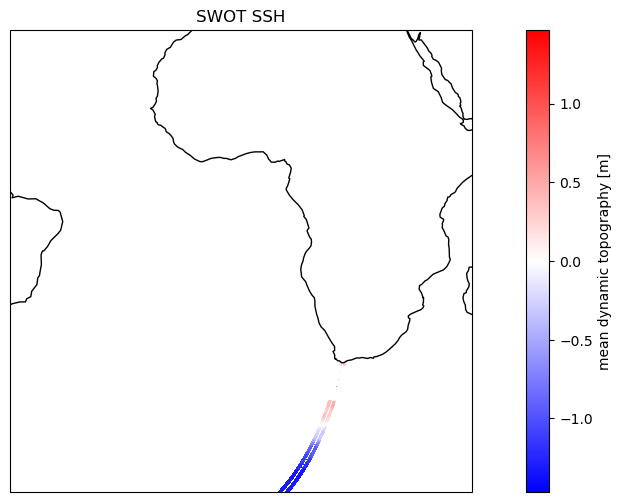

In [51]:
import cartopy
import cartopy.crs as ccrs
cartopy.config['data_dir']='/home3/sreich/.local/share/cartopy'
cartopy.config['pre_existing_data_dir']='/home3/sreich/.local/share/cartopy'

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_swot.ssh.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", cmap='bwr',add_colorbar=True
)
ax.coastlines()
ax.set_ylim([-60, 30])
ax.set_xlim([-45,45])
plt.title('SWOT SSH')

### Compute _interp fields

translated from /home/atnguyen/llc270/global/matlab/simple_ctd/

step02:
- xc and yc are reshaped from compact (nx, 13*nx) to worldmap (4*nx, 4*nx)
- prof_point/nearest_swot_index is computed relative to worldmap view
  
step04
- Line 43/44: xc and yc are turned from (4*nx, 4*nx) to 5-face view. Use patchface3D_wrld_to_5f. This is "direction 3" in matlab script patchface3D.m 
- FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
- Line 68: (I think — convince yourself) sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
- Line 69: Change each field from compact to worldmap (she has done so in her python function)
- Line 70: Use the prof_point (which was created relative to worldmap view) to grab the index from each field, which are now properly in worldmap view.

In [52]:
# step02:

# reshape xc, yc from compact (13*nx, nx) form to worldmap view (nz=1,4*nx, 4*nx)
nx = 1080

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')

xc = patchface3D(xc,nx,1)
yc = patchface3D(yc,nx,1)

llc_coords = np.c_[yc.ravel(), xc.ravel()]

# compute nearest_swot_index relative to worldmap view
kd_tree = KDTree(llc_coords)
distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)



1
(1080, 3240, 1)
1
(1080, 3240, 1)


1
(1080, 3240, 1)


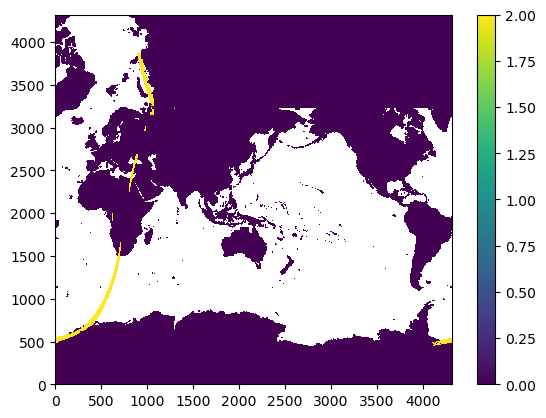

In [53]:
# plot to check 
#grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
#hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc_wrl = patchface3D(hfc, nx, 1)[0,:,:]
hfc_wrl.ravel()[nearest_swot_index_in_llc]= 2
#plt.pcolor(hfc_wrl*patchface3D(hfc, nx, 1)[0,:,:])
plt.pcolor(hfc_wrl)
plt.colorbar()

In [ ]:
# kd_tree = KDTree(llc_coords)
# import time
# # tic = time.perf_counter()
# # distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[:200000], k=1)
# # toc = time.perf_counter()
# # print(f"{toc - tic:0.4f} seconds")

# # tic = time.perf_counter()
# # distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[200000:400000], k=1)
# # toc = time.perf_counter()
# # print(f"{toc - tic:0.4f} seconds")

# tic = time.perf_counter()
# #distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[370000:380000], k=1)
# distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)
# toc = time.perf_counter()
# print(f"{toc - tic:0.4f} seconds")

# ############
# llc_coords.shape, swot_coords.shape
# #swot_coords[370000:380000]
# swot_coords.shape

# #ds_swot.where(~np.isnan(ds_swot.ssha_karin_2), drop=True)
# ############

# #(~np.isnan(ds_swot.ssha_karin_2) * ds_swot.latitude).plot()

# mask = ~np.isnan(ds_swot.ssha_karin_2)
# #mask[mask==0]=np.nan
# #(mask.where(mask==True).values * ds_swot.latitude).plot()


# ~np.isnan(ds_swot.ssha_karin_2) * ds_swot.latitude

# lats = mask.where(mask==True).values * ds_swot.latitude
# lons = mask.where(mask==True).values * ds_swot.longitude

# swot_coords = np.c_[lats.values.ravel(), lons.values.ravel()]

# swot_coords.shape

# ############

# nan_mask = np.isnan(swot_coords).all(axis=1)

# # Invert thef mask to keep rows where at least one element is not nan
# valid_rows = ~nan_mask

# # Filter out rows with nan elements
# cleaned_array = swot_coords[valid_rows]
# cleaned_array.shape




In [54]:
### step 4 ###

# transform xc and yc from worldmap (4*nx, 4*nx) to 5-face view
tileCount=0

xgrid = patchface3D_wrld_to_5f(xc)
ygrid = patchface3D_wrld_to_5f(yc)

for i in range(1,6):
    xgrid[i] = np.squeeze(xgrid[i])
    ygrid[i] = np.squeeze(ygrid[i])

XC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
XCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
iTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
jTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
tileNo=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))

# FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
for key in xgrid.keys():
    face_XC = xgrid[key] 
    face_YC = ygrid[key]
    for ii in range(int(face_XC.shape[1]/sNx)):
        for jj in range(int(face_XC.shape[0]/sNy)):
            tileCount += 1
            tmp_i = np.arange(sNx)+sNx*ii
            tmp_j = np.arange(sNy)+sNx*jj
            tmp_XC = face_XC[ np.ix_( tmp_j, tmp_i ) ]
            tmp_YC = face_YC[ np.ix_( tmp_j, tmp_i ) ]
            XC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[0,0]
            YC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[0,0]
            XCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[-1,-1]
            YCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[-1,-1]
            iTile[key][ np.ix_( tmp_j, tmp_i ) ] = np.ones((sNx,1)) * np.arange(1,sNy+1)
            jTile[key][ np.ix_( tmp_j, tmp_i ) ] = (np.arange(1,sNx+1) * np.ones((sNy,1))).T
            tileNo[key][ np.ix_( tmp_j, tmp_i ) ] = tileCount*np.ones((sNy,sNx))




In [55]:
tile_keys = ['XC11', 'YC11', 'XCNINJ', 'YCNINJ', 'i', 'j']
tile_vals = [XC11, YC11, XCNINJ, YCNINJ, iTile, jTile]
tile_data_in = dict(zip(tile_keys, tile_vals))
tile_dict = dict()
for key in tile_keys:

    # - Line 68: sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
    temp = tile_data_in[key]
    temp = np.concatenate((temp[1], temp[2], temp[3], temp[4].T, temp[5].T))

    # - Line 69: Change each field from compact to worldmap (she has done so in her python function)
    tile_data_in[key] = patchface3D(temp,nx,1)

    # - Line 70: Use the obs_point (which was created relative to worldmap view) to grab the index from each field, 
    # which are now properly in worldmap view.
    tile_dict['sample_interp_' + key] = tile_data_in[key].ravel()[nearest_swot_index_in_llc]

1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)
1
(1080, 3240, 1)


In [56]:
tile_dict['sample_interp_XC11'].shape, tile_dict

((680340,),
 {'sample_interp_XC11': array([-82.95834351, -82.95834351, -82.95834351, ...,  97.0526886 ,
          97.0526886 ,  97.0526886 ]),
  'sample_interp_YC11': array([-70.01380157, -70.01380157, -70.01380157, ...,  72.05986786,
          72.05986786,  72.05986786]),
  'sample_interp_XCNINJ': array([-69.38817596, -69.38817596, -69.38817596, ..., 123.05977631,
         123.05977631, 123.05977631]),
  'sample_interp_YCNINJ': array([-75.38358307, -75.38358307, -75.38358307, ...,  77.26180267,
          77.26180267,  77.26180267]),
  'sample_interp_i': array([90., 90., 90., ..., 89., 90., 90.]),
  'sample_interp_j': array([ 41.,  42.,  42., ..., 149., 147., 147.])})

### Add obs_interp_ fields to data

In [57]:
# reshape for num_lines, num_pixels
for key in tile_dict.keys():
    tile_dict[key] = tile_dict[key].reshape(ds_swot.ssha.shape)

# add interp fields to xarray
for key, item in tile_dict.items():
    dims = ('num_lines', 'num_pixels')  # Replace with your actual dimension names
    var_da = xr.DataArray(item, dims=dims, name=key)
    ds_swot[key] = var_da

In [58]:
ds_swot

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude              (num_lines, num_pixels) float64 -77.05 ... 77.05
    longitude             (num_lines, num_pixels) float64 -57.48 ... 109.4
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/23)
    time                  (num_lines) datetime64[ns] ...
    mdt                   (num_lines, num_pixels) float64 ...
    ssha                  (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha_noiseless        (num_lines, num_pixels) float64 ...
    ssha_unedited         (num_lines, num_pixels) float64 ...
    quality_flag          (num_lines, num_pixels) uint8 102 102 101 ... 102 102
    ...                    ...
    sample_interp_XC11    (num_lines, num_pixels) float64 -82.96 ... 97.05
    sample_interp_YC11    (num_lines, num_pixels) float64 -70.01 ... 72.06
    sample_interp_XCNINJ  (num_lines, num_pixels) float64 -69.39 ... 123.1
    sample_interp_YCNINJ  (num_lines, num_pixels) float64 -75.38 ... 77.26
    sample_interp_i       (num_lines, num_pixels) float64 90.0 90.0 ... 90.0
    sample_interp_j       (num_lines, num_pixels) float64 41.0 42.0 ... 147.0
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    time_coverage_begin:             2024-01-24T22:36:38Z
    time_coverage_end:               2024-01-24T23:28:05Z
    geospatial_lat_min:              -78.271942
    geospatial_lat_max:              78.272019
    geospatial_lon_min:              0.000133
    geospatial_lon_max:              359.999799

In [59]:
# up until this point, we have obsfit fields for each individual swot point
# now can group and average all swot ssha values in same llc grid square

df_swot = ds_swot.to_dataframe()
gb = df_swot.groupby(['sample_interp_XC11', 'sample_interp_YC11', 'sample_interp_XCNINJ', 'sample_interp_YCNINJ', 'sample_interp_i', 'sample_interp_j'])
counts = gb.size().to_frame(name='counts')
gb_stats = (counts
.join(gb.agg({'ssh': 'mean'}).rename(columns={'ssh': 'obs_val'}))
.join(gb.agg({'ssh': 'std'}).rename(columns={'ssh': 'ssh_std'}))
.join(gb.agg({'latitude': 'mean'}).rename(columns={'latitude': 'sample_x'}))
.join(gb.agg({'latitude': 'std'}).rename(columns={'latitude': 'latitude_std'}))
.join(gb.agg({'longitude': 'mean'}).rename(columns={'longitude': 'sample_y'}))
.join(gb.agg({'longitude': 'std'}).rename(columns={'longitude': 'longitude_std'}))
.join(gb.agg({'time': 'mean'}).rename(columns={'time': 'time_mean'}))
#.join(gb.agg({'time': 'std'}).rename(columns={'time': 'time_std'}))
.reset_index()
)

gb_stats

,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssh_std,sample_x,latitude_std,sample_y,longitude_std,time_mean
0,-82.958344,-70.013802,-69.388176,-75.383583,90.0,41.0,1,NaN,NaN,-77.053767,NaN,-57.480892,NaN,2024-01-24 22:36:38.807000064
1,-82.958344,-70.013802,-69.388176,-75.383583,90.0,42.0,2,NaN,NaN,-77.080639,0.012668,-57.480943,0.000024,2024-01-24 22:36:38.807000064
2,-82.958344,-70.013802,-69.388176,-75.383583,90.0,43.0,1,NaN,NaN,-77.107512,NaN,-57.480994,NaN,2024-01-24 22:36:38.807000064
3,-82.958344,-70.013802,-69.388176,-75.383583,93.0,41.0,1,NaN,NaN,-77.053762,NaN,-57.401080,NaN,2024-01-24 22:36:39.067259136
4,-82.958344,-70.013802,-69.388176,-75.383583,93.0,42.0,2,NaN,NaN,-77.080635,0.012668,-57.400963,0.000056,2024-01-24 22:36:39.067259136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86059,97.077477,78.509140,141.837952,82.116539,79.0,2.0,1,NaN,NaN,78.271588,NaN,109.078793,NaN,2024-01-24 23:28:04.283014912
86060,97.077477,78.509140,141.837952,82.116539,80.0,1.0,3,NaN,NaN,78.253824,0.017913,109.167685,0.000665,2024-01-24 23:28:04.603011072
86061,97.077477,78.509140,141.837952,82.116539,81.0,1.0,3,NaN,NaN,78.236126,0.017914,109.344266,0.000392,2024-01-24 23:28:05.243003648
86062,97.077477,78.509140,141.837952,82.116539,81.0,2.0,1,NaN,NaN,78.271953,NaN,109.343481,NaN,2024-01-24 23:28:05.243003648


### verify new interpolation gives similar results to old method

In [41]:
gb_stats_old = pd.read_csv('gb_stats_old.csv')
gb_stats_old

gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]
gb_stats_old = gb_stats_old[~np.isnan(gb_stats_old['ssha_karin_2_mean'])]

#tmp = np.sort(gb_stats_old.latitude.values) - np.sort(gb_stats.sample_y.values)
#np.nanmin(tmp), np.nanmax(tmp)
np.unique(np.unique(gb_stats.obs_val) - np.unique(gb_stats_old.ssha_karin_2_mean), return_counts=True)

### NOTE: gb_stats_old is llc90 but new is llc1080 eventually check this with same grid ####

ValueError: operands could not be broadcast together with shapes (54474,) (560,) 

## Create obsfit xarray

In [60]:
from datetime import datetime as dt

def datenum(d):
    return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

d = dt.strptime('2023-07-08 23:14:16.622514','%Y-%m-%d %H:%M:%S.%f')
dn = datenum(d)
d, dn

(datetime.datetime(2023, 7, 8, 23, 14, 16, 622514), 739075.9682479458)

In [61]:
gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]

gb_stats['obs_date'] = pd.to_datetime(gb_stats['time_mean']).apply(lambda x: datenum(x))
gb_stats['obs_YYYYMMDD'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%Y%m%d')))
gb_stats['obs_HHMMSS'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%H%M%S')))

gb_stats

/var/tmp/pbs.19336310.pbspl1.nas.nasa.gov/ipykernel_11437/1907508569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb_stats['obs_date'] = pd.to_datetime(gb_stats['time_mean']).apply(lambda x: datenum(x))
/var/tmp/pbs.19336310.pbspl1.nas.nasa.gov/ipykernel_11437/1907508569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb_stats['obs_YYYYMMDD'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%Y%m%d')))
/var/tmp/pbs.19336310.pbspl1.nas.nasa.gov/ipykernel_11437/1907508569.py:5: SettingWithCop

,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssh_std,sample_x,latitude_std,sample_y,longitude_std,time_mean,obs_date,obs_YYYYMMDD,obs_HHMMSS
2433,-38.560093,-76.222824,-23.041666,-70.018700,110.0,5.0,2,-1.082600,NaN,-76.178361,0.006071,-29.053010,0.046552,2024-01-24 22:38:33.347182592,739275.943442,20240124,223833
2434,-38.560093,-76.222824,-23.041666,-70.018700,110.0,6.0,3,-1.083000,0.001900,-76.144995,0.012331,-29.057992,0.032868,2024-01-24 22:38:33.607857920,739275.943445,20240124,223833
2435,-38.560093,-76.222824,-23.041666,-70.018700,110.0,7.0,2,-1.088200,NaN,-76.106147,0.017192,-29.047096,0.021029,2024-01-24 22:38:33.971489280,739275.943449,20240124,223833
2441,-38.560093,-76.222824,-23.041666,-70.018700,110.0,13.0,3,-1.103000,NaN,-75.909528,0.015721,-29.026917,0.035292,2024-01-24 22:38:35.700008192,739275.943469,20240124,223835
2442,-38.560093,-76.222824,-23.041666,-70.018700,110.0,14.0,2,-1.112100,NaN,-75.877355,0.011114,-29.015364,0.024911,2024-01-24 22:38:36.014321664,739275.943472,20240124,223836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57868,22.041666,38.304604,36.958332,48.367638,169.0,115.0,9,0.483456,0.008601,44.887531,0.015572,36.040865,0.021924,2024-01-24 23:15:36.070799360,739275.969167,20240124,231536
57869,22.041666,38.304604,36.958332,48.367638,169.0,116.0,10,0.492086,0.007040,44.941625,0.016959,36.040676,0.024619,2024-01-24 23:15:36.974239232,739275.969178,20240124,231536
57939,22.041666,38.304604,36.958332,48.367638,170.0,113.0,10,0.518200,NaN,44.779750,0.016959,36.125253,0.024548,2024-01-24 23:15:34.538976768,739275.969150,20240124,231534
57941,22.041666,38.304604,36.958332,48.367638,170.0,115.0,10,0.493300,0.004401,44.887924,0.016962,36.125013,0.024590,2024-01-24 23:15:36.351471104,739275.969171,20240124,231536


In [62]:
obs_weight = np.ones(len(gb_stats.sample_y.values))

obs = xr.Dataset(
    data_vars=dict(
        obs_date           =(["iOBS"], gb_stats.obs_date.values),
        obs_YYYYMMDD       =(["iOBS"], gb_stats.obs_YYYYMMDD.values),
        obs_HHMMSS         =(["iOBS"], gb_stats.obs_HHMMSS.values), 
        sample_x           =(["iSAMPLE"], gb_stats.sample_x.values),
        sample_y           =(["iSAMPLE"], gb_stats.sample_y.values),
        sample_z           =(["iSAMPLE"], np.zeros(len(gb_stats.sample_y.values))),
        sample_type        =(["iSAMPLE"], 5*np.ones(len(gb_stats.sample_y.values))),
        obs_val            =(["iOBS"], gb_stats.obs_val.values),
        obs_uncert         =(["iOBS"], np.sqrt(1/obs_weight)),
        sample_interp_XC11 =(["iOBS"], gb_stats.sample_interp_XC11.values ),
        sample_interp_YC11 =(["iOBS"], gb_stats.sample_interp_YC11.values ),
        sample_interp_XCNINJ =(["iOBS"], gb_stats.sample_interp_XCNINJ.values ),
        sample_interp_YCNINJ =(["iOBS"], gb_stats.sample_interp_YCNINJ.values ),
        sample_interp_i =(["iOBS"], gb_stats.sample_interp_i.values ),
        sample_interp_j =(["iOBS"], gb_stats.sample_interp_j.values ),
        sample_interp_w =(["iOBS", "iINTERP"], np.ones((len(gb_stats.sample_interp_i),8))/8  )
    ),
)

In [63]:
obs = obs.assign_coords({'longitude': obs.sample_x, 'latitude': obs.sample_y})
obs

<xarray.Dataset>
Dimensions:               (iOBS: 20370, iSAMPLE: 20370, iINTERP: 8)
Coordinates:
    longitude             (iSAMPLE) float64 -76.18 -76.14 -76.11 ... 44.89 44.94
    latitude              (iSAMPLE) float64 -29.05 -29.06 -29.05 ... 36.13 36.12
Dimensions without coordinates: iOBS, iSAMPLE, iINTERP
Data variables: (12/16)
    obs_date              (iOBS) float64 7.393e+05 7.393e+05 ... 7.393e+05
    obs_YYYYMMDD          (iOBS) int64 20240124 20240124 ... 20240124 20240124
    obs_HHMMSS            (iOBS) int64 223833 223833 223833 ... 231536 231537
    sample_x              (iSAMPLE) float64 -76.18 -76.14 -76.11 ... 44.89 44.94
    sample_y              (iSAMPLE) float64 -29.05 -29.06 -29.05 ... 36.13 36.12
    sample_z              (iSAMPLE) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                    ...
    sample_interp_YC11    (iOBS) float64 -76.22 -76.22 -76.22 ... 38.3 38.3 38.3
    sample_interp_XCNINJ  (iOBS) float64 -23.04 -23.04 -23.04 ... 36.96 36.96
    sample_interp_YCNINJ  (iOBS) float64 -70.02 -70.02 -70.02 ... 48.37 48.37
    sample_interp_i       (iOBS) float64 110.0 110.0 110.0 ... 170.0 170.0 170.0
    sample_interp_j       (iOBS) float64 5.0 6.0 7.0 13.0 ... 113.0 115.0 116.0
    sample_interp_w       (iOBS, iINTERP) float64 0.125 0.125 ... 0.125 0.125

In [47]:
data_dir = '/nobackup/sreich/swot/swot_obsfit_L2/'
fname = filename.split('.')[0] + '_obsfit.nc'
#obs.to_netcdf(data_dir + fname)

In [51]:
obsfit_nc = xr.open_dataset(data_dir + fname)
obsfit_nc.obs_val.values

array([-0.16523782, -0.18643998, -0.16684487, ...,  0.26722322,
        0.26269836,  0.25008466])

In [3]:
import numpy as np
import pandas as pd
import ecco_v4_py as ecco
import xarray as xr
from scipy.spatial import KDTree
import swot_ssh_utils as swot
import sys
sys.path.append('/home3/sreich/MITgcm_c68w/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

from patchface3D import *

### Load in LLC Grid ###

sNx = 180
sNy=sNx

grid_dir='/nobackup/sreich/llc1080_c68w_runs/run/'
hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc[hfc!=0]=np.nan
# Convert to dict of 5 faces, sizes [(270,90), (270,90), (90,90), (90,270), (90,270)]
hfc_faces = ecco.llc_compact_to_faces(hfc, less_output=True)

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')



### Read in SWOT Data from Input Args ###

pth = '/nobackup/sreich/swot/SWOT_L2_LR_SSH_2.0/Expert/'
filename = 'SWOT_L2_LR_SSH_Expert_009_001_20240104T033426_20240104T042554_PIC0_01.nc' # sys.argv[0] is name of python file


ds_swot = xr.open_dataset(pth + filename)
ds_swot = ds_swot.drop_dims('num_sides')
ds_swot['longitude'] = (ds_swot['longitude'] + 180) % 360 - 180

ds_swot_sub = ds_swot.where(ds_swot.ancillary_surface_classification_flag == 0, drop=True)
swot_coords = np.c_[ds_swot_sub.latitude.values.ravel(), ds_swot_sub.longitude.values.ravel()]

# apply corrections
ssha = ds_swot_sub.ssha_karin_2
flag = ds_swot_sub.ancillary_surface_classification_flag
ssha = np.where(flag == 0, ssha, np.nan)

distance = ds_swot_sub.cross_track_distance.values

ssha = swot.fit_bias(
        ssha, distance,
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )

ds_swot_sub.ssha_karin_2.values = ssha

ssha[np.abs(ssha) > 0.3] = np.nan
ds_swot_sub.ssha_karin_2.values = ssha



In [4]:
### Compute _interp fields ###

# reshape xc, yc from compact (13*nx, nx) form to worldmap view (nz=1,4*nx, 4*nx)
nx = 1080

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')

xc = patchface3D(xc,nx,1)
yc = patchface3D(yc,nx,1)

llc_coords = np.c_[yc.ravel(), xc.ravel()]

1
(1080, 3240, 1)
1
(1080, 3240, 1)
